To execute all the code blocks which I will be covering in this section, create a new Python notebook inside the “samples” folder of the cloned Mask_RCNN repository.

Let’s start by importing the required libraries:

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("D:/Program_files/Projects/Mask_RCNN")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

Next, we will define the path for the pretrained weights and the images on which we would like to perform segmentation:

In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

... done downloading pretrained model!


create an inference class which will be used to infer the Mask R-CNN model

In [6]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

The backbone is resnet101 as we have discussed earlier as well. The mask shape that will be returned by the model is 28X28, as it is trained on the COCO dataset. And we have a total of 81 classes (including the background).

We can also see various other statistics as well, like:

The input shape
Number of GPUs to be used
Validation steps, among other things.

Loading Weights

In [7]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

W0826 14:12:20.047633  2328 deprecation_wrapper.py:119] From C:\Users\phath\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 14:12:20.094540  2328 deprecation_wrapper.py:119] From C:\Users\phath\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 14:12:20.101561  2328 deprecation_wrapper.py:119] From C:\Users\phath\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 14:12:20.128531  2328 deprecation_wrapper.py:119] From C:\Users\phath\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:1919: The name tf.nn.fused_batch_n

Define the classes of the COCO dataset which will help us in the prediction phase

In [9]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

load an image and try to see how the model performs. You can use any of your images to test the model

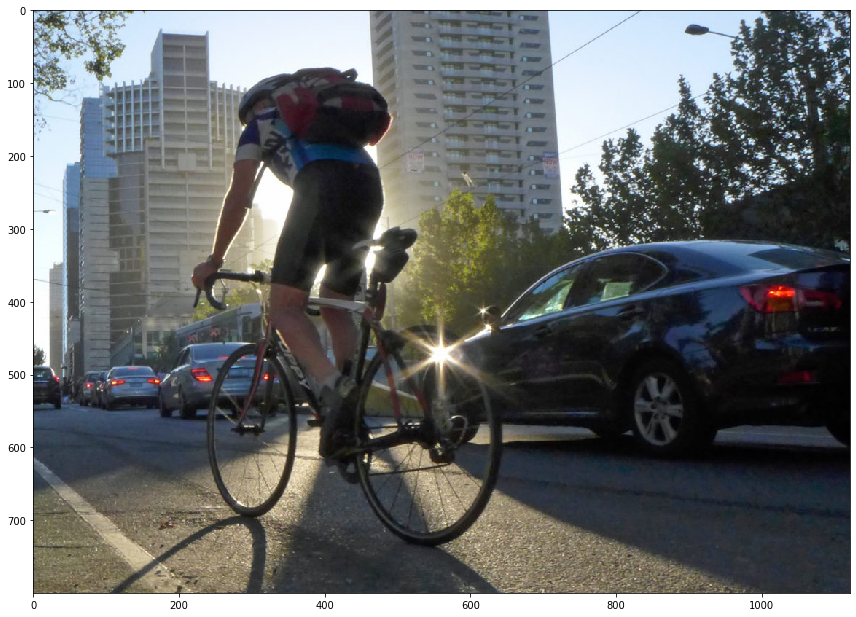

In [12]:
# Load a random image from the images folder
image = skimage.io.imread('cyclist.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

Making Predictions

We will use the Mask R-CNN model along with the pretrained weights and see how well it segments the objects in the image. We will first take the predictions from the model and then plot the results to visualize them

Processing 1 images
image                    shape: (800, 1121, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1121.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


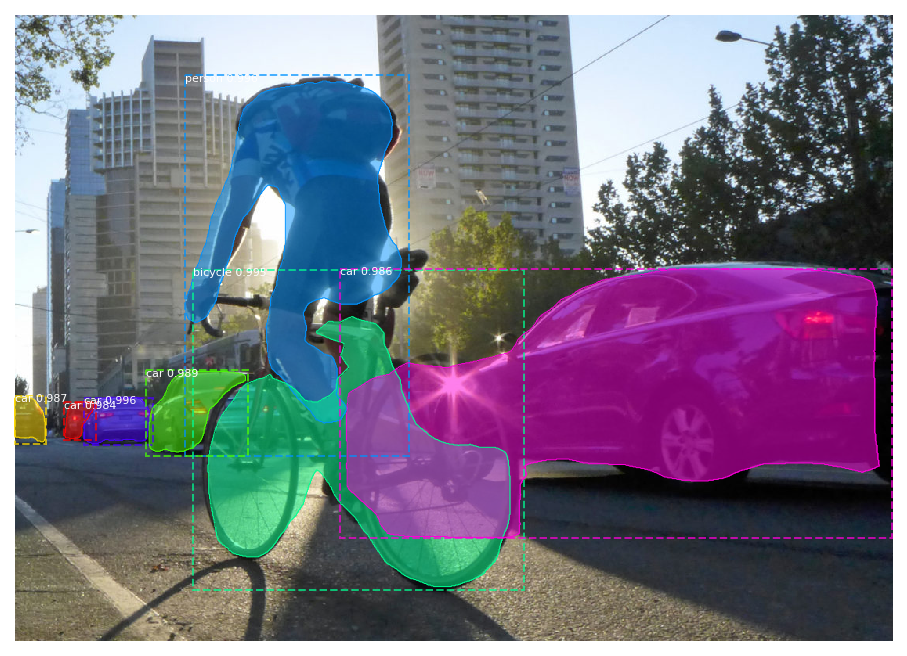

In [13]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

Interesting. The model has done pretty well to segment both the cars as well as the bicycle in the image. We can look at each mask or the segmented objects separately as well. Let’s see how we can do that.

I will first take all the masks predicted by our model and store them in the mask variable. Now, these masks are in the boolean form (True and False) and hence we need to convert them to numbers (1 and 0). Let’s do that first

In [14]:
mask = r['masks']
mask = mask.astype(int)
mask.shape

(800, 1121, 7)

This will give us an array of 0s and 1s, where 0 means that there is no object at that particular pixel and 1 means that there is an object at that pixel. Note that the shape of the mask is similar to that of the original image (you can verify that by printing the shape of the original image)

However, the 7 here in the shape of the mask does not represent the channels. Instead, it represents the number of objects segmented by our model. Since the model has identified 3 objects in the above sample image, the shape of the mask is (800, 1121, 7). Had there been 7 objects, this shape would have been (800, 1121, 7)

We now have the original image and the array of masks. To print or get each segment from the image, we will create a for loop and multiply each mask with the original image to get each segment

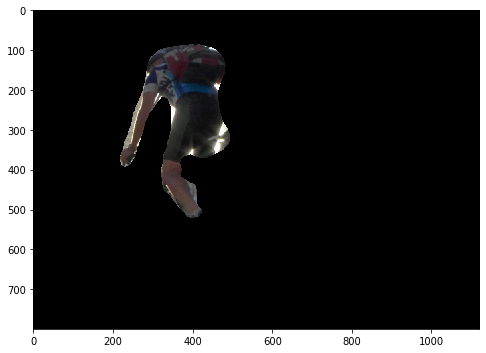

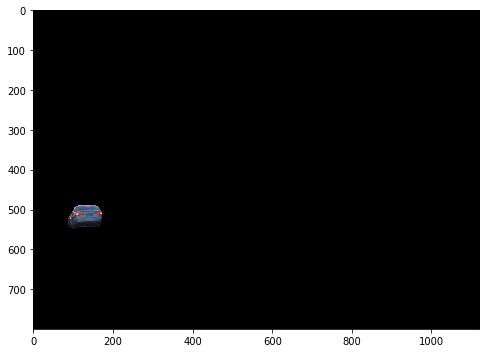

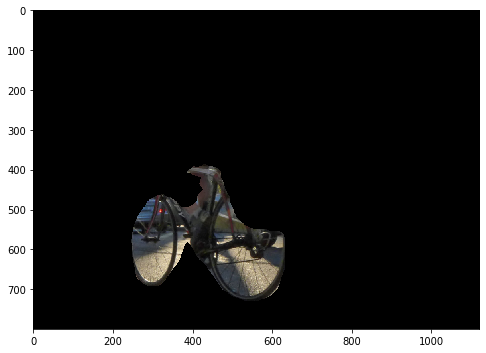

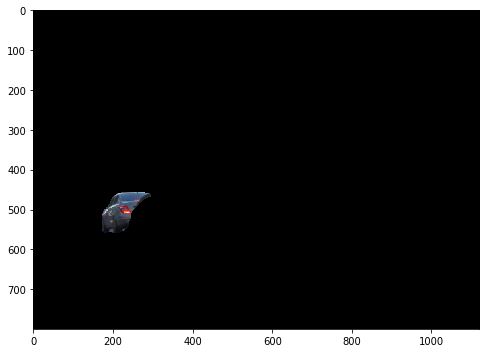

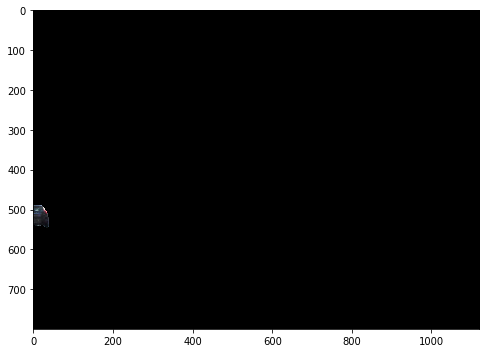

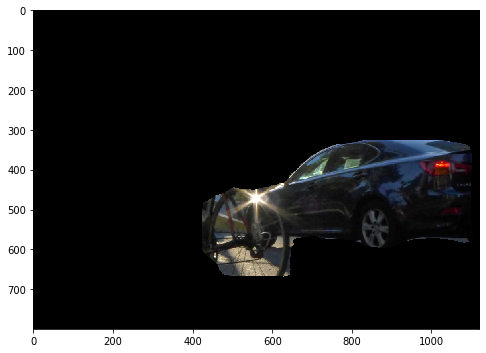

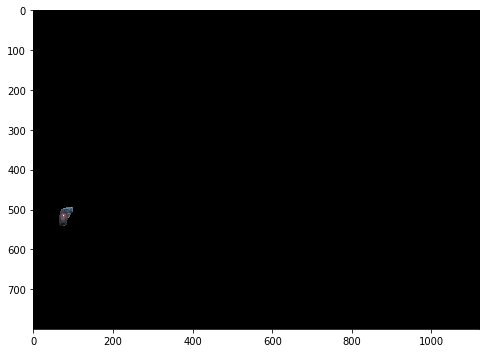

In [17]:
for i in range(mask.shape[2]):
    temp = skimage.io.imread('cyclist.jpg')
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)